<a href="https://colab.research.google.com/github/samcast1/Short-Term-Investments-Model/blob/main/notebooks/2_0_sc_cleaning_EDA_zillow_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning and EDA - Zillow Data

The Zillow research data comes in ~10 csv files that each represent a different metric of the real estate metric in various regions over time. I need to figure out the best way to use this data, which requires a good look and clean before deciding how to work the features for further modeling.

In [ ]:
!pip install pyspark
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5ecbeb09d188cd53612378d605f6c63a8b5115334243229015a904c834404142
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pyspark
import findspark
from pyspark.sql import SparkSession

ModuleNotFoundError: No module named 'pyspark'

In [ ]:
findspark.init()
spark = SparkSession.builder.appName('ShortTermInvestment').getOrCreate()
zhvi_top = spark.read.csv("zhvi_top_tier.csv", header=True, inferSchema=True)
zhvi_mid = spark.read.csv("zhvi_mid_tier.csv", header=True, inferSchema=True)
zhvi_bot = spark.read.csv("zhvi_bottom_tier.csv", header=True, inferSchema=True)
sales_count = spark.read.csv("sales_count.csv", header=True, inferSchema=True)
sales_med = spark.read.csv("sales_median.csv", header=True, inferSchema=True)
sales_list = spark.read.csv("sales_to_list_ratio.csv", header=True, inferSchema=True)
rental = spark.read.csv("rental_index.csv", header=True, inferSchema=True)
market_heat = spark.read.csv("market_heat_index.csv", header=True, inferSchema=True)

In [ ]:
zhvi_top.createOrReplaceTempView("top")
zhvi_mid.createOrReplaceTempView("mid")
zhvi_bot.createOrReplaceTempView("bot")

In [ ]:
def sql(query):
  result = spark.sql(query)
  result.show()
  return result

In [ ]:
sql("""
SELECT *
 FROM top
  LEFT JOIN mid
    USING (RegionName)
  LEFT JOIN bot
    USING (RegionName)
""")

+-----------------+--------+--------+----------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------

DataFrame[RegionName: string, RegionID: int, SizeRank: int, RegionType: string, StateName: string, 2000-01-31: double, 2000-02-29: double, 2000-03-31: double, 2000-04-30: double, 2000-05-31: double, 2000-06-30: double, 2000-07-31: double, 2000-08-31: double, 2000-09-30: double, 2000-10-31: double, 2000-11-30: double, 2000-12-31: double, 2001-01-31: double, 2001-02-28: double, 2001-03-31: double, 2001-04-30: double, 2001-05-31: double, 2001-06-30: double, 2001-07-31: double, 2001-08-31: double, 2001-09-30: double, 2001-10-31: double, 2001-11-30: double, 2001-12-31: double, 2002-01-31: double, 2002-02-28: double, 2002-03-31: double, 2002-04-30: double, 2002-05-31: double, 2002-06-30: double, 2002-07-31: double, 2002-08-31: double, 2002-09-30: double, 2002-10-31: double, 2002-11-30: double, 2002-12-31: double, 2003-01-31: double, 2003-02-28: double, 2003-03-31: double, 2003-04-30: double, 2003-05-31: double, 2003-06-30: double, 2003-07-31: double, 2003-08-31: double, 2003-09-30: double, 2

In [ ]:
sql("""
WITH cte AS(
  SELECT *
 FROM top
  LEFT JOIN mid
    USING (RegionName)
  LEFT JOIN bot
    USING (RegionName)
),

cte2 AS(
SELECT RegionName, COUNT(RegionName) AS total_region, COUNT(DISTINCT(RegionName)) AS unique_region
FROM cte
GROUP BY RegionName
)

SELECT SUM(total_region) AS sum_total, SUM(unique_region) AS sum_unique
FROM cte2
"""
)

+---------+----------+
|sum_total|sum_unique|
+---------+----------+
|      895|       895|
+---------+----------+



DataFrame[sum_total: bigint, sum_unique: bigint]

In [ ]:
zdf = sql("""SELECT  top.RegionName AS top_RegionName,
mid.RegionName AS mid_RegionName,
bot.RegionName AS bot_RegionName,
*
 FROM top
  LEFT JOIN mid
    USING (RegionName)
  LEFT JOIN bot
    USING (RegionName)""").toPandas()

+-----------------+-----------------+-----------------+-----------------+--------+--------+----------+---------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------

In [ ]:
zdf.describe()

,RegionID,SizeRank,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,...,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30
count,895.000000,895.000000,434.000000,435.000000,435.000000,437.000000,439.000000,4.400000e+02,4.410000e+02,4.420000e+02,...,892.000000,892.000000,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02
mean,412099.672626,461.751955,205488.148596,205654.821505,206062.624765,207360.238760,208531.050566,2.095820e+05,2.110583e+05,2.122833e+05,...,178661.254574,179543.529825,1.802459e+05,1.807078e+05,1.811009e+05,1.812918e+05,1.813965e+05,1.817366e+05,1.828185e+05,1.844334e+05
std,78377.355083,268.710532,106063.507886,106359.878391,106866.371855,108136.988193,109244.440430,1.105920e+05,1.121684e+05,1.137501e+05,...,122923.899946,123938.391497,1.247651e+05,1.254155e+05,1.258209e+05,1.261082e+05,1.263070e+05,1.265422e+05,1.269238e+05,1.274021e+05
min,102001.000000,0.000000,95489.518917,95822.849169,96109.830499,96489.707186,96743.920141,9.696288e+04,9.721674e+04,9.746208e+04,...,21645.242401,21584.513412,2.182411e+04,2.205085e+04,2.228219e+04,2.226661e+04,2.221277e+04,2.209836e+04,2.238761e+04,2.286062e+04
25%,394546.000000,230.500000,148862.635222,148781.328711,148962.443648,149289.081884,150095.422552,1.505237e+05,1.512987e+05,1.520069e+05,...,97828.671888,97882.413583,9.755642e+04,9.716307e+04,9.739422e+04,9.729159e+04,9.736073e+04,9.729437e+04,9.823960e+04,9.962280e+04
50%,394795.000000,460.000000,178331.106144,178754.697330,178821.806249,179396.494070,180355.538266,1.809996e+05,1.816813e+05,1.820520e+05,...,142864.802103,143498.196350,1.436050e+05,1.440752e+05,1.442340e+05,1.446428e+05,1.447582e+05,1.452905e+05,1.461118e+05,1.474986e+05
75%,395044.500000,689.500000,226690.600434,226911.141330,227439.144080,228135.366995,228786.662826,2.289348e+05,2.305113e+05,2.311060e+05,...,220955.290532,222993.525792,2.240713e+05,2.250312e+05,2.252425e+05,2.251346e+05,2.253863e+05,2.266423e+05,2.281964e+05,2.290442e+05
max,753929.000000,939.000000,977258.110081,980498.074647,983802.744659,990731.732589,997961.760527,1.005827e+06,1.014720e+06,1.025013e+06,...,980104.751485,994355.932851,1.010371e+06,1.025017e+06,1.036951e+06,1.044964e+06,1.046114e+06,1.043687e+06,1.043426e+06,1.048310e+06


In [ ]:
zdf[['RegionName','SizeRank']]

,RegionName,SizeRank,SizeRank,SizeRank
0,United States,0,0,0.0
1,"New York, NY",1,1,1.0
2,"Los Angeles, CA",2,2,2.0
3,"Chicago, IL",3,3,3.0
4,"Dallas, TX",4,4,4.0
...,...,...,...,...
890,"Zapata, TX",935,935,NaN
891,"Ketchikan, AK",936,936,936.0
892,"Craig, CO",937,937,937.0
893,"Vernon, TX",938,938,938.0


In [ ]:
zdf.RegionName.duplicated().any()

False

In [ ]:
print(zdf.top_RegionName.isna().any())
print(zdf.mid_RegionName.isna().any())
print(zdf.bot_RegionName.isna().any())

False
False
True


In [ ]:
zdf[['top_RegionName','mid_RegionName','bot_RegionName']].isna().value_counts()

top_RegionName  mid_RegionName  bot_RegionName
False           False           False             892
                                True                3
Name: count, dtype: int64

In [ ]:
zdf.loc[zdf['bot_RegionName'].isna(),:]

,top_RegionName,mid_RegionName,bot_RegionName,RegionName,RegionID,SizeRank,RegionType,StateName,2000-01-31,2000-02-29,...,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30
587,"Morgan City, LA","Morgan City, LA",None,"Morgan City, LA",394878,605,msa,LA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
712,"Mount Vernon, IL","Mount Vernon, IL",None,"Mount Vernon, IL",394888,731,msa,IL,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
890,"Zapata, TX","Zapata, TX",None,"Zapata, TX",753929,935,msa,TX,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
zdf.columns

Index(['top_RegionName', 'mid_RegionName', 'bot_RegionName', 'RegionName',
       'RegionID', 'SizeRank', 'RegionType', 'StateName', '2000-01-31',
       '2000-02-29',
       ...
       '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
       '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30'],
      dtype='object', length=939)

In [ ]:
zdf.loc[zdf['top_RegionName'].isna() == False, :].iloc[:, 8:].isna().sum()

2000-01-31    461
2000-02-29    460
2000-03-31    460
2000-04-30    458
2000-05-31    456
             ... 
2023-12-31      3
2024-01-31      3
2024-02-29      3
2024-03-31      3
2024-04-30      3
Length: 931, dtype: int64

In [ ]:
zdf.loc[zdf['top_RegionName'].isna(), :]

,top_RegionName,mid_RegionName,bot_RegionName,RegionName,RegionID,SizeRank,RegionType,StateName,2000-01-31,2000-02-29,...,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30


In [ ]:
zdf

,top_RegionName,mid_RegionName,bot_RegionName,RegionName,RegionID,SizeRank,RegionType,StateName,2000-01-31,2000-02-29,...,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30
0,United States,United States,United States,United States,102001,0,country,None,240169.983761,240706.319131,...,185881.893440,186854.630214,187603.071789,188158.665570,188582.152971,188848.478787,189074.833929,189573.622650,190692.571990,192220.026169
1,"New York, NY","New York, NY","New York, NY","New York, NY",394913,1,msa,NY,425262.242258,427062.742186,...,420095.416765,423086.254584,425671.678992,427993.325677,430268.545847,432843.187036,435509.775596,438810.250632,442897.023210,447366.790359
2,"Los Angeles, CA","Los Angeles, CA","Los Angeles, CA","Los Angeles, CA",753899,2,msa,CA,436932.633449,438674.441356,...,644293.489202,653907.308099,663684.354648,672070.377136,678992.879249,683989.530759,684772.394204,682312.850763,680051.685622,680655.597726
3,"Chicago, IL","Chicago, IL","Chicago, IL","Chicago, IL",394463,3,msa,IL,298081.849061,298447.586098,...,193646.608213,195489.036777,197069.643991,198388.365853,199335.185684,200013.764866,200517.695676,201590.059512,203344.788295,205702.338731
4,"Dallas, TX","Dallas, TX","Dallas, TX","Dallas, TX",394514,4,msa,TX,239522.832029,239527.356466,...,262611.693362,263538.287144,264128.173440,264567.680088,264433.358789,264235.323238,264460.984300,265129.301580,266199.003434,266959.121493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,"Zapata, TX","Zapata, TX",None,"Zapata, TX",753929,935,msa,TX,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
891,"Ketchikan, AK","Ketchikan, AK","Ketchikan, AK","Ketchikan, AK",394743,936,msa,AK,NaN,NaN,...,230469.680412,231054.217465,230919.602746,229677.350148,228744.178243,227357.404240,227539.845493,227584.319889,228684.329114,229380.249372
892,"Craig, CO","Craig, CO","Craig, CO","Craig, CO",753874,937,msa,CO,171336.684617,171651.042637,...,178545.629236,181081.800288,182920.412300,184549.656185,185433.722216,185508.206709,184982.639300,185080.291005,185780.329948,186724.579077
893,"Vernon, TX","Vernon, TX","Vernon, TX","Vernon, TX",395188,938,msa,TX,NaN,NaN,...,55092.928205,54231.377583,53999.511882,53749.672132,53383.214852,52844.876743,52418.327109,52269.091305,52609.851513,53021.754939


In [4]:
zdft = pd.read_csv('zhvi_top_tier.csv')
zdfm = pd.read_csv('zhvi_mid_tier.csv')
zdfb = pd.read_csv('zhvi_bottom_tier.csv')

In [5]:
zdft[zdft['RegionName'] == 'United States'].values.tolist()[0][5:]

[240169.9837613301,
 240706.31913133545,
 241358.9775865468,
 242751.58537316028,
 244338.99497406557,
 246046.53939527148,
 247863.7923449932,
 249803.05404512948,
 251801.2347123948,
 253783.6709617297,
 255735.6911106809,
 257667.2860373772,
 259438.9493422356,
 261077.67245194805,
 262721.4102632641,
 264508.0188253772,
 266363.48860297335,
 268190.92148799385,
 270025.0398974665,
 271924.00049121905,
 273841.88403740147,
 275737.1826740485,
 277494.54063626804,
 279111.1581330547,
 280559.96846326184,
 281986.24503259023,
 283505.26495132333,
 285187.989410276,
 287050.57566209615,
 289084.43810639204,
 291348.3562608806,
 293790.84953727067,
 296288.6776987993,
 298761.1671154105,
 301132.7429193787,
 303428.124640186,
 305536.3579785323,
 307580.4269832671,
 309690.94511123706,
 311964.7201682907,
 314411.400067324,
 316834.1971779375,
 319357.83772837854,
 322014.7639308362,
 324866.98348488566,
 327721.2282913163,
 330427.35716670845,
 332987.8924364084,
 335541.24531547487,
 

In [7]:
print(len(zdft.iloc[:, 5:].columns))
print(len(zdft[zdft['RegionName'] == 'United States'].values.tolist()[0][5:]))

292
292


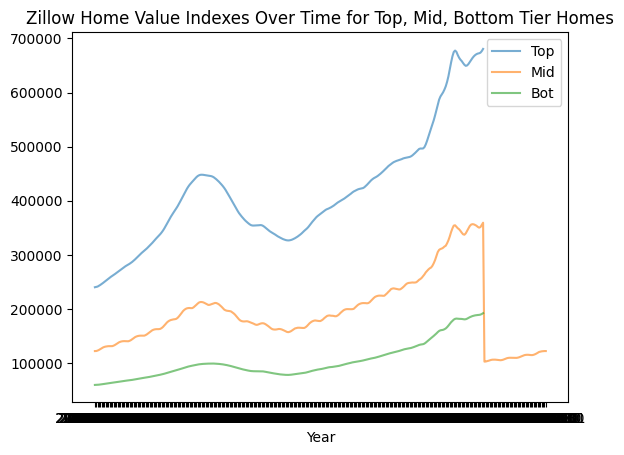

In [10]:
xtop = zdft.iloc[:,5:].columns
ytop = zdft[zdft['RegionName'] == 'United States'].values.tolist()[0][5:]

xmid = zdfm.iloc[:,5:].columns
ymid = zdfm[zdfm['RegionName'] == 'United States'].values.tolist()[0][5:]

xbot = zdfb.iloc[:,5:].columns
ybot = zdfb[zdfb['RegionName'] == 'United States'].values.tolist()[0][5:]

sns.lineplot(x = xtop, y = ytop, alpha = 0.6, label = 'Top', errorbar = None, legend = 'brief')
sns.lineplot(x = xmid, y = ymid, alpha = 0.6, label = 'Mid', errorbar = None, legend = 'brief')
sns.lineplot(x = xbot, y = ybot, alpha = 0.6, label = 'Bot', errorbar = None, legend = 'brief')

plt.title('Zillow Home Value Indexes Over Time for Top, Mid, Bottom Tier Homes')
plt.xlabel('Year')
plt.show()

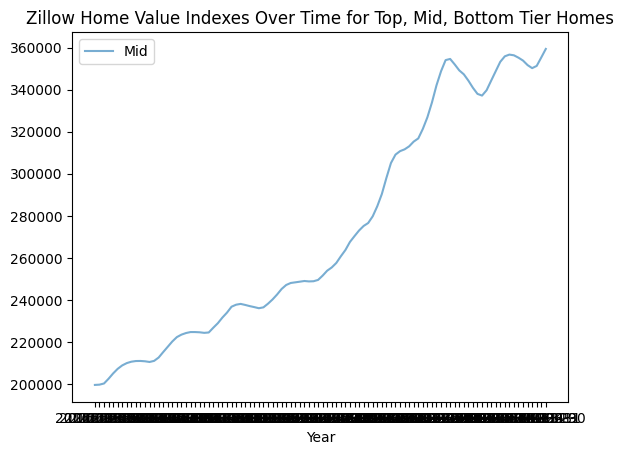

In [9]:
xmid = zdfm.iloc[:,-100:].columns
ymid = zdfm[zdfm['RegionName'] == 'United States'].values.tolist()[0][-100:]

sns.lineplot(x = xmid, y = ymid, alpha = 0.6, label = 'Mid', errorbar = None, legend = 'brief')

plt.title('Zillow Home Value Indexes Over Time for Top, Mid, Bottom Tier Homes')
plt.xlabel('Year')
plt.show()

In [13]:
print(len(xmid))
print(len(xtop))
print(len(xbot))

339
292
292


In [15]:
print(zdfm.columns)
print(zdft.columns)
print(zdfb.columns)

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       '1996-02-29', '1996-03-31', '1996-04-30', '1996-05-31', '1996-06-30',
       ...
       '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
       '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30'],
      dtype='object', length=344)
Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31',
       ...
       '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
       '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30'],
      dtype='object', length=297)
Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31',
       ...
       '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
       '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31', '2

Ah. zdfm provides dates beginning in 1996, whereas the otheres begin at 2000. The difference in length is 339 - 292 = 47. I don't need that pre 2000 data, so I can just remove the first 47 date columns from zdfm and see if that fixes my visual.

In [48]:
zdfm = zdfm.drop(zdfm.columns[5:52], axis=1)
zdfm.to_csv('/content/zhvi_mid_tier_trimmed.csv')

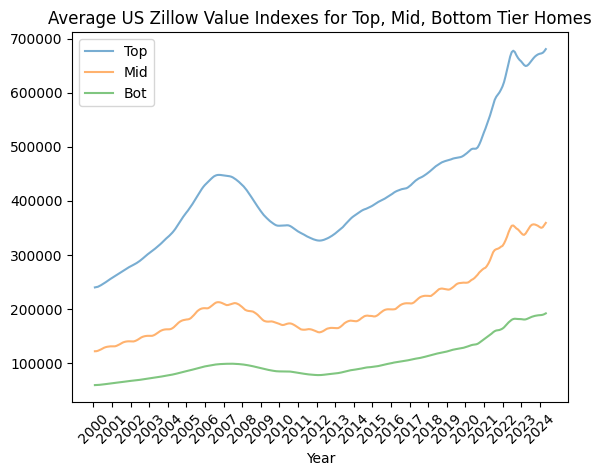

In [46]:
dates = zdft.iloc[5:].columns.tolist()[0][1:]

xtop = pd.to_datetime(zdft.iloc[:, 5:].columns, format='mixed')
ytop = zdft[zdft['RegionName'] == 'United States'].values.tolist()[0][5:]

xmid = pd.to_datetime(zdfm.iloc[:, 5:].columns, format='mixed')
ymid = zdfm[zdfm['RegionName'] == 'United States'].values.tolist()[0][5:]

xbot = pd.to_datetime(zdfb.iloc[:, 5:].columns, format='mixed')
ybot = zdfb[zdfb['RegionName'] == 'United States'].values.tolist()[0][5:]

g = sns.lineplot(x = xtop, y = ytop, alpha = 0.6, label = 'Top', errorbar = None, legend = 'brief')
f = sns.lineplot(x = xmid, y = ymid, alpha = 0.6, label = 'Mid', errorbar = None, legend = 'brief')
h = sns.lineplot(x = xbot, y = ybot, alpha = 0.6, label = 'Bot', errorbar = None, legend = 'brief')

plt.title('Average US Zillow Value Indexes for Top, Mid, Bottom Tier Homes')
plt.xlabel('Year')

years = range(2000, 2025)
plt.xticks(pd.date_range(start='2000-01-01', end='2024-04-30', freq='YS'), years)
plt.xticks(rotation=45)


plt.show()

ZHVI patterns are interesting.We can see the quick spike before the 2008 recession and subsequent fall, and then the major spike in 2020 due to covid. But, it looks like higher value homes fluctuate in value much more in response to these economic shifts.

I have this data for 894 cities.

The objective here is to find a way to combine this information with the other zillow data to produce a holistic measure of rental investment return.

Let's look at the market heat index, which describes the balance of for-sale supply and demand - higher numbers indicate a sellers' market.



In [50]:
mhdf = pd.read_csv('market_heat_index.csv')
print(mhdf.info())
mhdf.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 81 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    928 non-null    int64  
 1   SizeRank    928 non-null    int64  
 2   RegionName  928 non-null    object 
 3   RegionType  928 non-null    object 
 4   StateName   927 non-null    object 
 5   2018-01-31  879 non-null    float64
 6   2018-02-28  862 non-null    float64
 7   2018-03-31  859 non-null    float64
 8   2018-04-30  867 non-null    float64
 9   2018-05-31  872 non-null    float64
 10  2018-06-30  881 non-null    float64
 11  2018-07-31  879 non-null    float64
 12  2018-08-31  873 non-null    float64
 13  2018-09-30  871 non-null    float64
 14  2018-10-31  867 non-null    float64
 15  2018-11-30  884 non-null    float64
 16  2018-12-31  879 non-null    float64
 17  2019-01-31  882 non-null    float64
 18  2019-02-28  887 non-null    float64
 19  2019-03-31  890 non-null    f

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30
0,102001,0,United States,country,NaN,49.0,49.0,52.0,54.0,54.0,...,63.0,61.0,58.0,54.0,53.0,55.0,58.0,61.0,61.0,60.0
1,394913,1,"New York, NY",msa,NY,50.0,51.0,54.0,56.0,55.0,...,83.0,81.0,75.0,66.0,65.0,73.0,84.0,90.0,87.0,85.0
2,753899,2,"Los Angeles, CA",msa,CA,69.0,66.0,66.0,67.0,66.0,...,79.0,76.0,73.0,72.0,72.0,77.0,81.0,84.0,82.0,80.0
3,394463,3,"Chicago, IL",msa,IL,48.0,49.0,52.0,53.0,51.0,...,70.0,67.0,64.0,60.0,59.0,62.0,68.0,74.0,76.0,75.0
4,394514,4,"Dallas, TX",msa,TX,57.0,57.0,59.0,61.0,60.0,...,66.0,63.0,59.0,56.0,58.0,61.0,65.0,66.0,65.0,63.0


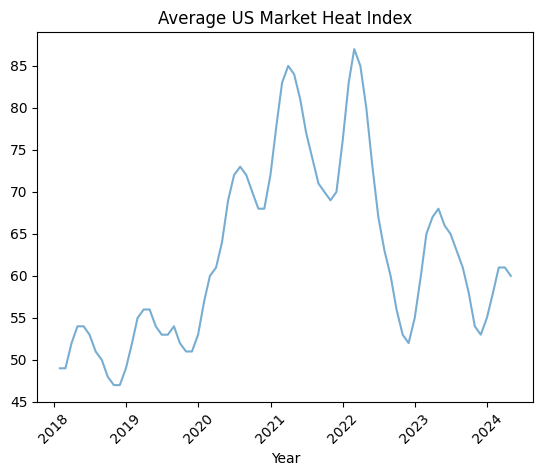

In [51]:
xmh = pd.to_datetime(mhdf.iloc[:, 5:].columns, format='mixed')
ymh = mhdf[mhdf['RegionName'] == 'United States'].values.tolist()[0][5:]

g = sns.lineplot(x = xmh, y = ymh, alpha = 0.6, errorbar = None, legend = 'brief')

plt.title('Average US Market Heat Index')
plt.xlabel('Year')

years = range(2018, 2025)
plt.xticks(pd.date_range(start='2018-01-01', end='2024-04-30', freq='YS'), years)
plt.xticks(rotation=45)

plt.show();

### Sales to List Ratio . . .
Higher value indicates that sale price is typically higher than listing price, indicating a sellers' market. Values in the df indicate median values.

In [53]:
sldf = pd.read_csv('sales_to_list_ratio.csv')
sldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 80 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    591 non-null    int64  
 1   SizeRank    591 non-null    int64  
 2   RegionName  591 non-null    object 
 3   RegionType  591 non-null    object 
 4   StateName   590 non-null    object 
 5   2018-01-31  298 non-null    float64
 6   2018-02-28  303 non-null    float64
 7   2018-03-31  318 non-null    float64
 8   2018-04-30  321 non-null    float64
 9   2018-05-31  323 non-null    float64
 10  2018-06-30  323 non-null    float64
 11  2018-07-31  326 non-null    float64
 12  2018-08-31  327 non-null    float64
 13  2018-09-30  328 non-null    float64
 14  2018-10-31  330 non-null    float64
 15  2018-11-30  334 non-null    float64
 16  2018-12-31  336 non-null    float64
 17  2019-01-31  339 non-null    float64
 18  2019-02-28  352 non-null    float64
 19  2019-03-31  362 non-null    f

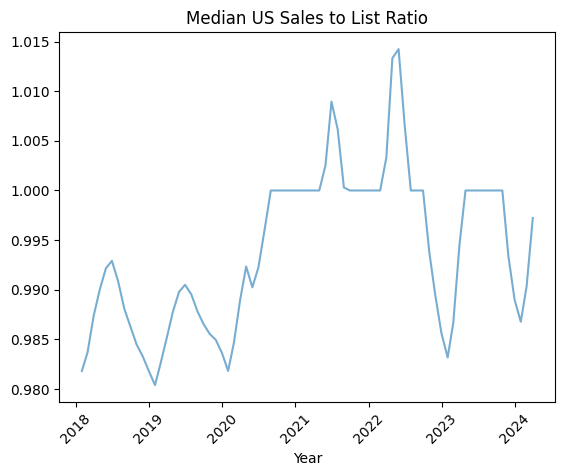

In [55]:
xsl = pd.to_datetime(sldf.iloc[:, 5:].columns, format='mixed')
ysl = sldf[sldf['RegionName'] == 'United States'].values.tolist()[0][5:]

g = sns.lineplot(x = xsl, y = ysl, alpha = 0.6, errorbar = None, legend = 'brief')

plt.title('Median US Sales to List Ratio')
plt.xlabel('Year')

years = range(2018, 2025)
plt.xticks(pd.date_range(start='2018-01-01', end='2024-04-30', freq='YS'), years)
plt.xticks(rotation=45)

plt.show();

In [57]:
scdf = pd.read_csv('sales_count.csv')
print(scdf.info())
scdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Columns: 200 entries, RegionID to 2024-04-30
dtypes: float64(195), int64(2), object(3)
memory usage: 147.0+ KB
None


,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30
0,102001,0,United States,country,NaN,202692.0,235042.0,261003.0,287517.0,300910.0,...,328126.0,356800.0,309839.0,297251.0,259324.0,247732.0,212019.0,234364.0,280861.0,313141.0
1,394913,1,"New York, NY",msa,NY,8468.0,8922.0,9864.0,10155.0,10757.0,...,13762.0,15830.0,13321.0,12754.0,10698.0,10419.0,9922.0,8549.0,9564.0,10220.0
2,753899,2,"Los Angeles, CA",msa,CA,4149.0,5051.0,6075.0,6883.0,7234.0,...,6217.0,6972.0,5746.0,5787.0,5119.0,4983.0,4406.0,4975.0,6040.0,6661.0
3,394463,3,"Chicago, IL",msa,IL,5757.0,7238.0,7469.0,8183.0,9058.0,...,9547.0,10372.0,8707.0,8330.0,7008.0,7150.0,5511.0,5785.0,7814.0,9139.0
4,394514,4,"Dallas, TX",msa,TX,5000.0,5666.0,6154.0,6846.0,6837.0,...,6895.0,7071.0,5752.0,5354.0,4726.0,4777.0,4271.0,5232.0,6225.0,7117.0


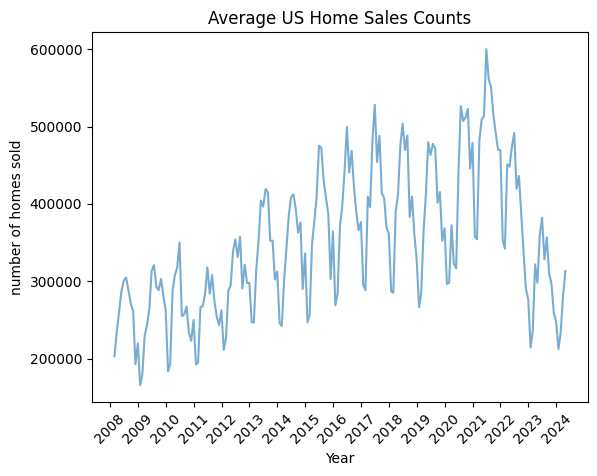

In [65]:
xsc = pd.to_datetime(scdf.iloc[:, 5:].columns, format='mixed')
ysc = scdf[scdf['RegionName'] == 'United States'].values.tolist()[0][5:]

g = sns.lineplot(x = xsc, y = ysc, alpha = 0.6, errorbar = None, legend = 'brief')

plt.title('Average US Home Sales Counts')
plt.xlabel('Year')
plt.ylabel('number of homes sold')

years = range(2008, 2025)
plt.xticks(pd.date_range(start='2008-01-01', end='2024-04-30', freq='YS'), years)
plt.xticks(rotation=45)

plt.show();

In [61]:
svdf = pd.read_csv('sales_median.csv')
print(svdf.info())
svdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Columns: 199 entries, RegionID to 2024-03-31
dtypes: float64(194), int64(2), object(3)
memory usage: 1.1+ MB
None


,RegionID,SizeRank,RegionName,RegionType,StateName,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,...,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31
0,102001,0,United States,country,NaN,172500.0,177500.0,179000.0,180000.0,185000.0,...,350000.0,349900.0,345000.0,335000.0,330000.0,325000.0,322500.0,325000.0,335000.0,345511.0
1,394913,1,"New York, NY",msa,NY,399900.0,390000.0,390390.0,395000.0,400000.0,...,565000.0,575000.0,595000.0,570000.0,553444.0,565000.0,561000.0,565000.0,557500.0,570000.0
2,753899,2,"Los Angeles, CA",msa,CA,470000.0,455000.0,458000.0,440000.0,435000.0,...,880000.0,885000.0,892000.0,880000.0,890000.0,900000.0,870750.0,865000.0,915500.0,920000.0
3,394463,3,"Chicago, IL",msa,IL,218000.0,221575.0,221796.0,228000.0,235000.0,...,320000.0,310000.0,305000.0,295000.0,285000.0,285000.0,280000.0,280000.0,285000.0,305000.0
4,394514,4,"Dallas, TX",msa,TX,138000.0,145900.0,144900.0,150000.0,155500.0,...,400000.0,395000.0,387000.0,379465.0,375000.0,373000.0,367372.0,367350.0,380000.0,390000.0


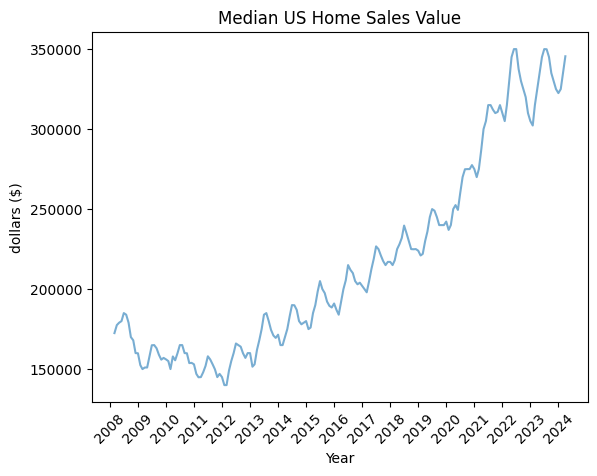

In [64]:
xsv = pd.to_datetime(svdf.iloc[:, 5:].columns, format='mixed')
ysv = svdf[svdf['RegionName'] == 'United States'].values.tolist()[0][5:]

g = sns.lineplot(x = xsv, y = ysv, alpha = 0.6, errorbar = None, legend = 'brief')

plt.title('Median US Home Sales Value')
plt.xlabel('Year')
plt.ylabel('dollars ($)')

years = range(2008, 2025)
plt.xticks(pd.date_range(start='2008-01-01', end='2024-04-30', freq='YS'), years)
plt.xticks(rotation=45)

plt.show();

In [66]:
pcdf = pd.read_csv('median_price_cuts.csv')
print(pcdf.info())
pcdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 81 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    702 non-null    int64  
 1   SizeRank    702 non-null    int64  
 2   RegionName  702 non-null    object 
 3   RegionType  702 non-null    object 
 4   StateName   701 non-null    object 
 5   2018-01-31  322 non-null    float64
 6   2018-02-28  322 non-null    float64
 7   2018-03-31  322 non-null    float64
 8   2018-04-30  322 non-null    float64
 9   2018-05-31  323 non-null    float64
 10  2018-06-30  323 non-null    float64
 11  2018-07-31  323 non-null    float64
 12  2018-08-31  323 non-null    float64
 13  2018-09-30  323 non-null    float64
 14  2018-10-31  323 non-null    float64
 15  2018-11-30  323 non-null    float64
 16  2018-12-31  323 non-null    float64
 17  2019-01-31  324 non-null    float64
 18  2019-02-28  324 non-null    float64
 19  2019-03-31  324 non-null    f

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30
0,102001,0,United States,country,NaN,7000.0,7600.0,8900.0,9100.0,9900.0,...,10001.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,394913,1,"New York, NY",msa,NY,15001.0,16000.0,19751.5,20000.0,20000.0,...,25000.0,25000.0,25100.0,25010.0,25000.0,21000.0,25000.0,25000.0,25000.0,26000.0
2,753899,2,"Los Angeles, CA",msa,CA,20000.0,20000.0,20000.0,20000.0,20000.0,...,48000.0,38000.0,39000.0,35000.0,30000.0,30000.0,34000.0,30000.5,34000.0,40012.0
3,394463,3,"Chicago, IL",msa,IL,5600.0,8000.0,9100.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,9000.0,10000.0,10000.0,10000.0,10000.0
4,394514,4,"Dallas, TX",msa,TX,8000.0,8562.0,9900.0,9500.0,9900.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0


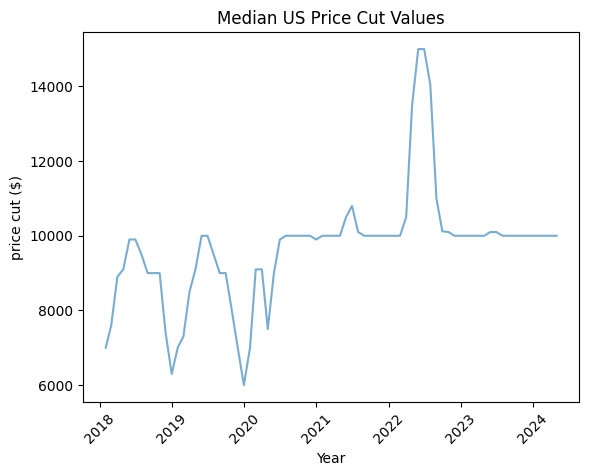

In [68]:
xpc = pd.to_datetime(pcdf.iloc[:, 5:].columns, format='mixed')
ypc = pcdf[pcdf['RegionName'] == 'United States'].values.tolist()[0][5:]

g = sns.lineplot(x = xpc, y = ypc, alpha = 0.6, errorbar = None, legend = 'brief')

plt.title('Median US Price Cut Values')
plt.xlabel('Year')
plt.ylabel('price cut ($)')

years = range(2018, 2025)
plt.xticks(pd.date_range(start='2018-01-01', end='2024-04-30', freq='YS'), years)
plt.xticks(rotation=45)

plt.show();

In [69]:
csdf = pd.read_csv('price_cut_share.csv')
print(csdf.info())
csdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 81 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    926 non-null    int64  
 1   SizeRank    926 non-null    int64  
 2   RegionName  926 non-null    object 
 3   RegionType  926 non-null    object 
 4   StateName   925 non-null    object 
 5   2018-01-31  890 non-null    float64
 6   2018-02-28  890 non-null    float64
 7   2018-03-31  890 non-null    float64
 8   2018-04-30  890 non-null    float64
 9   2018-05-31  890 non-null    float64
 10  2018-06-30  890 non-null    float64
 11  2018-07-31  890 non-null    float64
 12  2018-08-31  890 non-null    float64
 13  2018-09-30  890 non-null    float64
 14  2018-10-31  890 non-null    float64
 15  2018-11-30  890 non-null    float64
 16  2018-12-31  890 non-null    float64
 17  2019-01-31  890 non-null    float64
 18  2019-02-28  890 non-null    float64
 19  2019-03-31  890 non-null    f

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30
0,102001,0,United States,country,NaN,0.147669,0.139205,0.153134,0.162307,0.185487,...,0.217685,0.233899,0.238533,0.251342,0.225658,0.155183,0.208119,0.200172,0.205623,0.224277
1,394913,1,"New York, NY",msa,NY,0.125282,0.112987,0.122063,0.149563,0.173783,...,0.123675,0.120955,0.141000,0.154622,0.130736,0.080106,0.116543,0.103205,0.110621,0.124272
2,753899,2,"Los Angeles, CA",msa,CA,0.148645,0.136310,0.157305,0.169089,0.198798,...,0.155589,0.175402,0.185076,0.195263,0.177133,0.115061,0.154395,0.138993,0.145391,0.150384
3,394463,3,"Chicago, IL",msa,IL,0.193284,0.175242,0.200803,0.240246,0.274916,...,0.221946,0.240347,0.251693,0.259066,0.240755,0.154270,0.182866,0.166597,0.165863,0.187514
4,394514,4,"Dallas, TX",msa,TX,0.178063,0.146886,0.174182,0.186732,0.224750,...,0.312972,0.331840,0.319832,0.333670,0.295485,0.202124,0.264335,0.257752,0.253948,0.291083


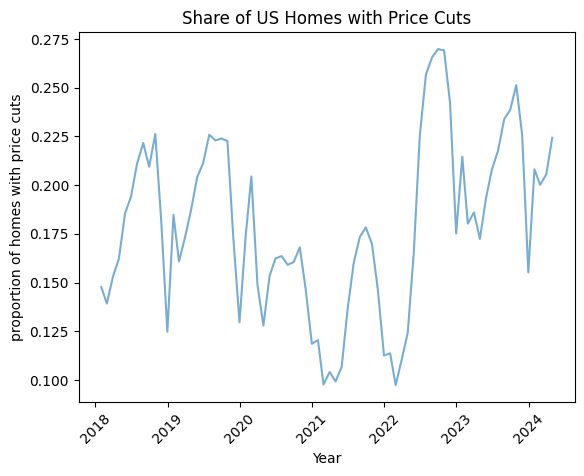

In [71]:
xcs = pd.to_datetime(csdf.iloc[:, 5:].columns, format='mixed')
ycs = csdf[csdf['RegionName'] == 'United States'].values.tolist()[0][5:]

g = sns.lineplot(x = xcs, y = ycs, alpha = 0.6, errorbar = None, legend = 'brief')

plt.title('Share of US Homes with Price Cuts')
plt.xlabel('Year')
plt.ylabel('proportion of homes with price cuts')

years = range(2018, 2025)
plt.xticks(pd.date_range(start='2018-01-01', end='2024-04-30', freq='YS'), years)
plt.xticks(rotation=45)

plt.show();

In [72]:
dpdf = pd.read_csv('median_days_to_pending.csv')
print(dpdf.info())
dpdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 81 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionID    766 non-null    int64  
 1   SizeRank    766 non-null    int64  
 2   RegionName  766 non-null    object 
 3   RegionType  766 non-null    object 
 4   StateName   765 non-null    object 
 5   2018-01-31  370 non-null    float64
 6   2018-02-28  373 non-null    float64
 7   2018-03-31  375 non-null    float64
 8   2018-04-30  378 non-null    float64
 9   2018-05-31  378 non-null    float64
 10  2018-06-30  379 non-null    float64
 11  2018-07-31  381 non-null    float64
 12  2018-08-31  382 non-null    float64
 13  2018-09-30  382 non-null    float64
 14  2018-10-31  383 non-null    float64
 15  2018-11-30  388 non-null    float64
 16  2018-12-31  390 non-null    float64
 17  2019-01-31  402 non-null    float64
 18  2019-02-28  405 non-null    float64
 19  2019-03-31  410 non-null    f

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30
0,102001,0,United States,country,NaN,47.0,25.0,20.0,18.0,18.0,...,12.0,13.0,15.0,16.0,21.0,30.0,29.0,17.0,13.0,13.0
1,394913,1,"New York, NY",msa,NY,86.0,51.0,37.0,41.0,37.0,...,27.0,26.0,27.0,27.0,30.0,39.0,43.0,26.0,21.0,22.0
2,753899,2,"Los Angeles, CA",msa,CA,21.0,14.0,15.0,14.0,15.0,...,13.0,14.0,15.0,15.0,17.0,22.0,18.0,14.0,13.0,13.0
3,394463,3,"Chicago, IL",msa,IL,57.0,23.0,15.0,14.0,15.0,...,8.0,8.0,10.0,11.0,14.0,22.0,19.0,9.0,7.0,6.0
4,394514,4,"Dallas, TX",msa,TX,37.0,24.0,21.0,19.0,20.0,...,14.0,18.0,20.0,20.0,27.0,34.0,35.0,19.0,15.0,14.0


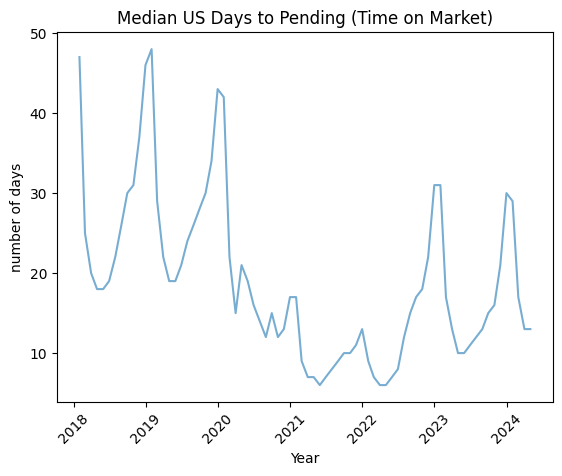

In [76]:
xdp = pd.to_datetime(dpdf.iloc[:, 5:].columns, format='mixed')
ydp = dpdf[dpdf['RegionName'] == 'United States'].values.tolist()[0][5:]

g = sns.lineplot(x = xdp, y = ydp, alpha = 0.6, errorbar = None, legend = 'brief')

plt.title('Median US Days to Pending (Time on Market)')
plt.xlabel('Year')
plt.ylabel('number of days')

years = range(2018, 2025)
plt.xticks(pd.date_range(start='2018-01-01', end='2024-04-30', freq='YS'), years)
plt.xticks(rotation=45)

plt.show();

Here's the deal:

I have eight datasets that each speak to the value of homes by region over time, which means they can each aid in forecasting the value of homes.

- group into meaningful variables
- group again into less meaningful but effective predictor
- combine with sentiment analysis
- create NN model to predict zhvi
